# Set Up the Environment

### Importing Libraries

In [ ]:

%pip install torchmetrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import torchvision
from torchvision import transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure
from transformers import AutoModelForDepthEstimation
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights
import time
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

### Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


# Define Needed Classes & Functions

### Class for Depth Model

In [3]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        predicted_depth = F.interpolate(predicted_depth.unsqueeze(1), size=(384, 384), mode='bilinear', align_corners=False)
        return predicted_depth

### Class for Student Model

In [4]:
class StudentModel(nn.Module):
    """
    Student model with MobileNetV3 encoder and a custom decoder.
    Designed for real-time inference on edge devices.
    """
    def __init__(self):
        super(StudentModel, self).__init__()
        # mobilenet = mobilenet_v3_large(wieghts=MobileNet_V3_Large_Weights.IMAGENET1K_V1)
        mobilenet = mobilenet_v3_large(pretrained=True)

        self.encoder = mobilenet.features


        self.decoder = nn.Sequential(
            nn.Conv2d(960, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),

            #output layer: reduces channels to 1 for depth prediction
            nn.Conv2d(32, 1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        x = F.interpolate(x, size=(384, 384), mode='bilinear', align_corners=False)
        return x


### Class for Dataset Loading & Preprocessing

In [5]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image

### Distillation Loss

In [6]:
class DepthDistillationLoss(nn.Module):
    """
    Custom loss function for depth distillation.
    Using Pixel wise MSE Loss, SSIM, Gradient MAE Loss, and Scale-Invariant MSE Loss.
    """
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, window_size=11):
        super().__init__()
        self.lambda_depth = lambda_depth  # Weight for depth map MSE loss
        self.lambda_si = lambda_si        # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad    # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim    # Weight for SSIM loss

        self.mse_depth_loss = nn.MSELoss()  # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss()          # L1 Loss for gradients

        # Initialize the SSIM calculation from torchmetrics
        if self.lambda_ssim > 0:
            self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=window_size)

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)

        # Ensure tensors have a channel dimension for SSIM
        if student_depth.dim() == 3: # Assuming (Batch, Height, Width)
            student_depth = student_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)
        if teacher_depth.dim() == 3: # Assuming (Batch, Height, Width)
            teacher_depth = teacher_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)


        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
            diff = student_depth - teacher_depth
            loss_si = torch.mean(diff**2) - torch.mean(diff)**2
            total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4. SSIM Loss
        if self.lambda_ssim > 0:
            # Move ssim module to the same device as the tensors
            self.ssim.to(student_depth.device)

            # The torchmetrics SSIM implementation returns a value between -1 and 1.
            # A value of 1 indicates perfect similarity.
            # To use it as a loss, we subtract it from 1.
            d_ssim = self.ssim(student_depth, teacher_depth)
            loss_ssim = (1 - d_ssim) / 2 # Normalize to be between 0 and 1
            total_loss += self.lambda_ssim * loss_ssim

        return total_loss

### The Training Function

In [7]:
def train_knowledge_distillation(teacher, student, dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode
    student.train() # Student in training mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    models = []
    x = 0
    for epoch in range(epochs):
        running_loss = 0.0
        start_time = time.time()

        for batch_idx, inputs in enumerate(dataloader):
            inputs = inputs.to(device)

            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(inputs) # Returns depth map

            # Forward pass with Student model
            student_outputs = student(inputs) # Returns depth map

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (batch_idx + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {running_loss / (batch_idx+1):.4f}")

        epoch_loss = running_loss / len(dataloader)
        end_time = time.time()
        print(f"Epoch {epoch+1} finished. Avg Loss: {epoch_loss:.4f}, Time: {end_time - start_time:.2f}s")

        # Save student model checkpoint periodically
        if(epoch+1)%5 == 0:
          models.append(student)
          # torch.save(student.state_dict(), f"/content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")
          # print(f"Student model saved to /content/drive/MyDrive/distill_any_depth_student_epoch_{epoch+1}.pth")

    print("Knowledge Distillation Training Finished!")
    return models

# Training Process

### Define Parameters & Models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

!wget -c https://example.com/path/to/nyu_depth_v2_data.zip -O /content/drive/MyDrive/nyu_depth_v2_data.zip

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Large-hf").to(device)


teacher_model = DepthModel(teacher).to(device)

# student  model architecture
student_model = StudentModel().to(device)

# Initialize optimizer for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)

# Training parameters
num_epochs = 30

# Distillation Loss
# Instantiate the custom loss function
distillation_criterion = DepthDistillationLoss(lambda_depth=0.1,  lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, window_size=11)

# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with 50% probability
    transforms.RandomRotation(degrees=10),   # Randomly rotate the image by +/- 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)), # Crop a random part of the image and resize it
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
])

eval_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform)
unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=5, shuffle=True, num_workers=2)



Using device: cuda
--2025-07-15 07:22:11--  https://example.com/path/to/nyu_depth_v2_data.zip
Resolving example.com (example.com)... 23.192.228.80, 23.192.228.84, 23.215.0.136, ...
Connecting to example.com (example.com)|23.192.228.80|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-07-15 07:22:11 ERROR 404: Not Found.



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 68.3MB/s]


Found 48 images in /content/drive/MyDrive/images/


Befor Training

In [9]:
# Load train image
image_path = "/content/drive/MyDrive/images/img1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [10]:
# --- Verify which layers are trainable ---
print("All parameters in student_model:")
for name, param in student_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")

print("----------------------------------------")
for name, param in student_model.named_parameters():
    param.requires_grad = False

# Unfreeze parameters in the 'head' layer
for name, param in student_model.decoder.named_parameters():
    param.requires_grad = True

# --- Verify which layers are trainable ---
print("Trainable parameters in student_model:")
for name, param in student_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}")


All parameters in student_model:
  encoder.0.0.weight
  encoder.0.1.weight
  encoder.0.1.bias
  encoder.1.block.0.0.weight
  encoder.1.block.0.1.weight
  encoder.1.block.0.1.bias
  encoder.1.block.1.0.weight
  encoder.1.block.1.1.weight
  encoder.1.block.1.1.bias
  encoder.2.block.0.0.weight
  encoder.2.block.0.1.weight
  encoder.2.block.0.1.bias
  encoder.2.block.1.0.weight
  encoder.2.block.1.1.weight
  encoder.2.block.1.1.bias
  encoder.2.block.2.0.weight
  encoder.2.block.2.1.weight
  encoder.2.block.2.1.bias
  encoder.3.block.0.0.weight
  encoder.3.block.0.1.weight
  encoder.3.block.0.1.bias
  encoder.3.block.1.0.weight
  encoder.3.block.1.1.weight
  encoder.3.block.1.1.bias
  encoder.3.block.2.0.weight
  encoder.3.block.2.1.weight
  encoder.3.block.2.1.bias
  encoder.4.block.0.0.weight
  encoder.4.block.0.1.weight
  encoder.4.block.0.1.bias
  encoder.4.block.1.0.weight
  encoder.4.block.1.1.weight
  encoder.4.block.1.1.bias
  encoder.4.block.2.fc1.weight
  encoder.4.block.2.fc1.b

### Run the Training

In [14]:
    # Run the training
mods = train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    dataloader=unlabeled_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")


Starting Knowledge Distillation Training on cuda...
Epoch 1 finished. Avg Loss: 4352.9386, Time: 10.55s
Epoch 2 finished. Avg Loss: 4032.8334, Time: 11.88s
Epoch 3 finished. Avg Loss: 3977.7445, Time: 16.29s
Epoch 4 finished. Avg Loss: 4520.6739, Time: 10.23s
Epoch 5 finished. Avg Loss: 4116.7040, Time: 12.16s
Epoch 6 finished. Avg Loss: 4220.8310, Time: 11.37s
Epoch 7 finished. Avg Loss: 3894.8946, Time: 11.84s
Epoch 8 finished. Avg Loss: 3847.9075, Time: 10.55s
Epoch 9 finished. Avg Loss: 4032.3904, Time: 10.35s
Epoch 10 finished. Avg Loss: 4440.8121, Time: 11.35s
Epoch 11 finished. Avg Loss: 3727.0473, Time: 11.66s
Epoch 12 finished. Avg Loss: 4127.4876, Time: 11.58s
Epoch 13 finished. Avg Loss: 3981.8959, Time: 11.34s
Epoch 14 finished. Avg Loss: 3629.3689, Time: 11.06s
Epoch 15 finished. Avg Loss: 4040.0212, Time: 10.20s
Epoch 16 finished. Avg Loss: 3831.6721, Time: 11.69s
Epoch 17 finished. Avg Loss: 3607.9193, Time: 10.87s
Epoch 18 finished. Avg Loss: 3636.0151, Time: 12.71s
Epo

# Evaluation

### On training

✅ Student model inference time: 10.65 ms


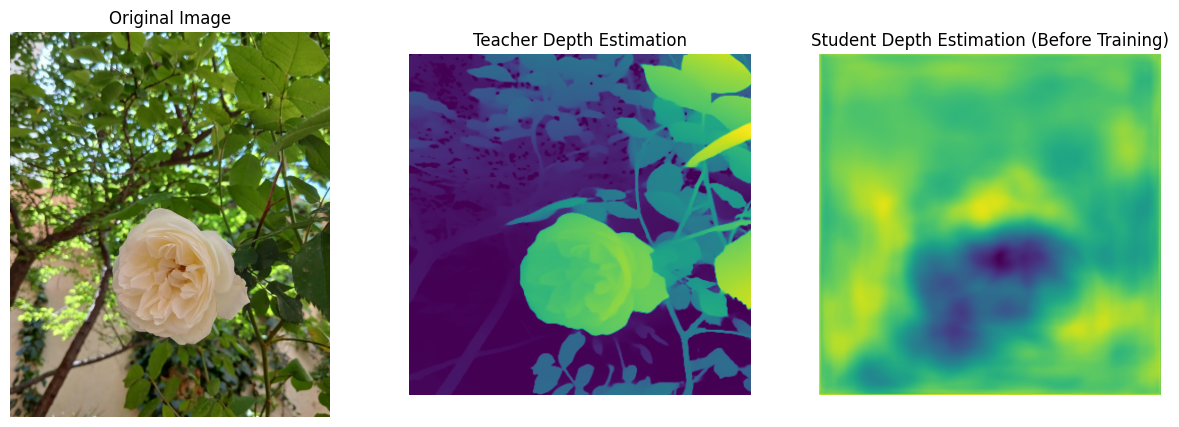

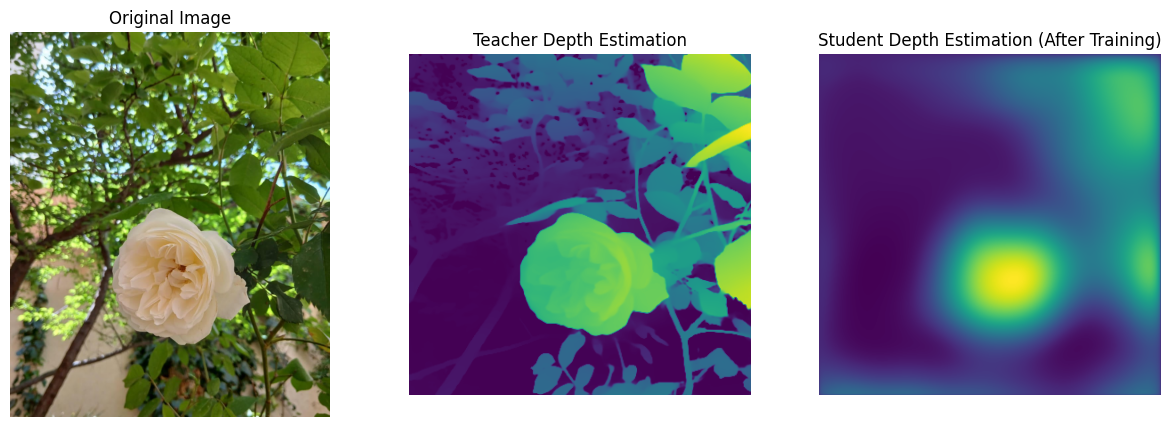

In [12]:
# Load image
image_path = "/content/drive/MyDrive/images/img1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



### On Testing

6932.82177734375


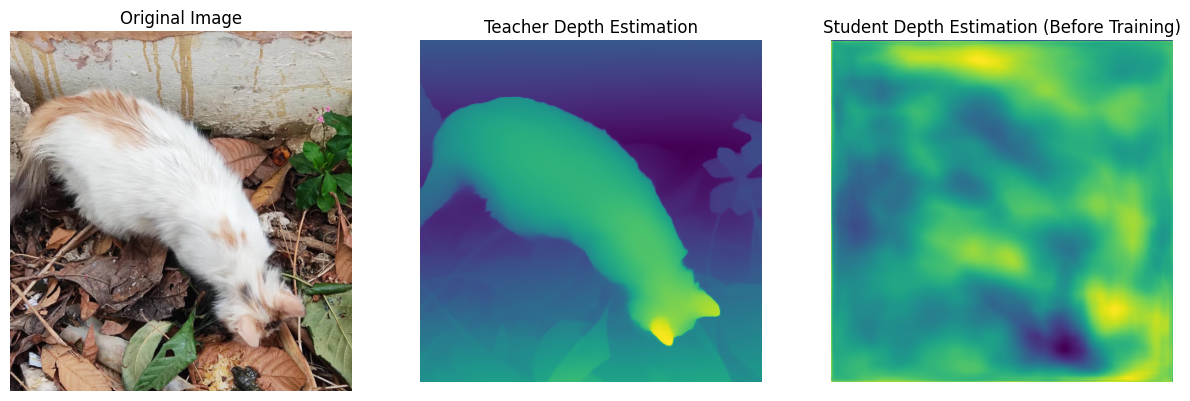

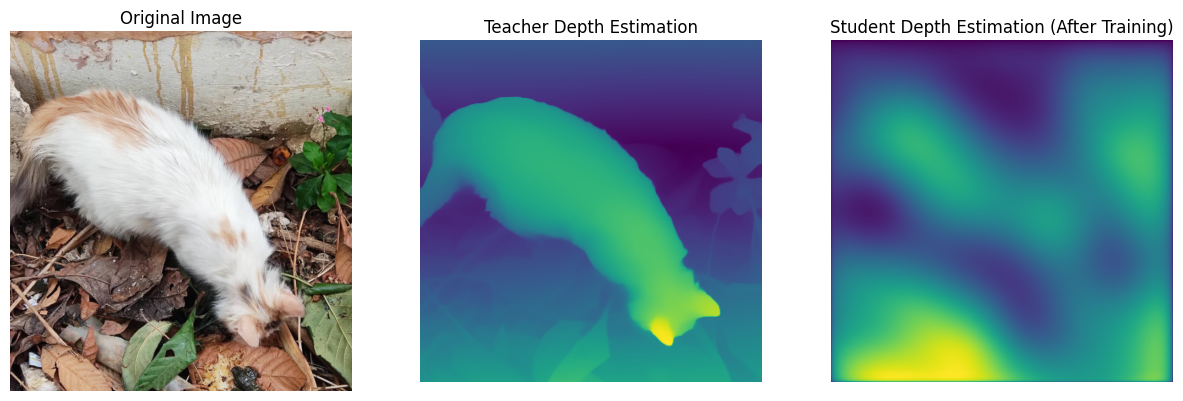

In [13]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()